The purpose of this notebook is to provide a sample project building and documenting challenger models from the perspective of Independent Model Validation on Enterprise Risk Management model documentation requirements.This notebook defines a common problem type: binary classficiation problem using Titanic dataset, and it does not cover every nuance that are found in different models. This effort right now primarily address the design of Model Developent and Outcome Analysis sections in [Model Validation Documentaion Guidance](https://collab.sfcollab.org/sites/wss000112/Independent%20Review/Independent%20Review/Documentation%20Guidelines/documentation_details_2019_FinalDraft.docx)


### EDA and SR identified the following challenger models and model scoring metrics to be utilized for Binary Classification problem:

### Challenger models:
    - logistic regression, 
    - bagging ensemble methods(e.g. random forest) , 
    - boosting ensemble methods(e.g. gradient boosting machine), 
    - anomaly detection method(e.g. isolation forest), 
    - ensemble voting classifer.

### Scoring metrics:
    - accuracy, 
    - auc roc, 
    - precision, 
    - recall, 
    - f1 score, 
    - lift chart, 
    - fitting time, 
    - score time
    


This notebook provides example of what was tried, the discussion of pros and cons among different models, and the rational of why a given approach was chosen for the given business problem. The AIMRM team will be updating this document as we get feedback from modelers during model validations and as Enterprise Risk Management policies and procedures are updated. Please consult with the AIMRM team if you have any questions. 

Possible future work:
- Keep evaluating TPOT, an auto-ml library with a focus on reproducibility
- Data profiling and Performance Monitoring


### Contents of the Notebook:
#### Part1: Exploratory Data Analysis(EDA):

1)Analysis of the features.

2)Finding any relations or trends considering multiple features.
#### Part2: Feature Engineering and Data Cleaning:

1)Adding any few features.

2)Removing redundant features.

3)Converting features into suitable form for modeling.
#### Part3: Predictive Modeling

1)Running challenger models using CV and recording scoring metrics

2)Model comparison and pros/cons discussion

3)Model selection


## Part1: Exploratory Data Analysis(EDA)

In [54]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [55]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("data/train.csv")
test_df    = pd.read_csv("data/test.csv")

# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [56]:
print (titanic_df.isnull().sum()) #checking for total null values
print (test_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


How many Survived??

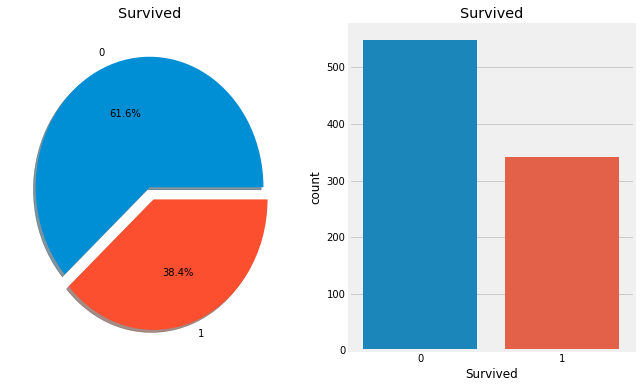

In [57]:
f,ax=plt.subplots(1,2,figsize=(10,6))
titanic_df['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=titanic_df,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

It is evident that not many passengers survived the accident.

Out of 891 passengers in training set, only around 350 survived i.e Only 38.4% of the total training set survived the crash. We need to dig down more to get better insights from the data and see which categories of the passengers did survive and who didn't.

## Part2: Feature Engineering and Data Cleaning

Types Of Features
#### Categorical Features:

A categorical variable is one that has two or more categories and each value in that feature can be categorised by them.For example, gender is a categorical variable having two categories (male and female). Now we cannot sort or give any ordering to such variables. They are also known as Nominal Variables.

Categorical Features in the dataset: Sex,Embarked.
#### Ordinal Features:

An ordinal variable is similar to categorical values, but the difference between them is that we can have relative ordering or sorting between the values. For eg: If we have a feature like Height with values Tall, Medium, Short, then Height is a ordinal variable. Here we can have a relative sort in the variable.

Ordinal Features in the dataset: PClass
#### Continous Feature:

A feature is said to be continous if it can take values between any two points or between the minimum or maximum values in the features column.

Continous Features in the dataset: Age


In [58]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

### Categorical Features

0

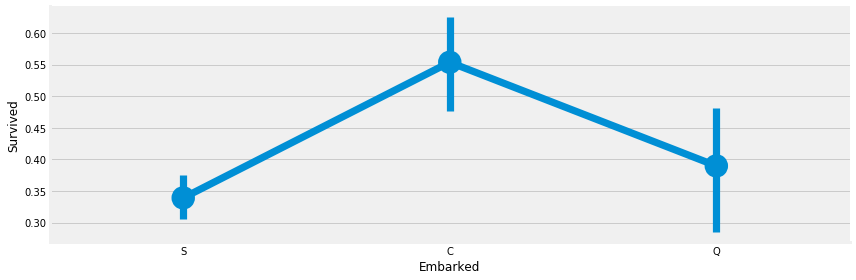

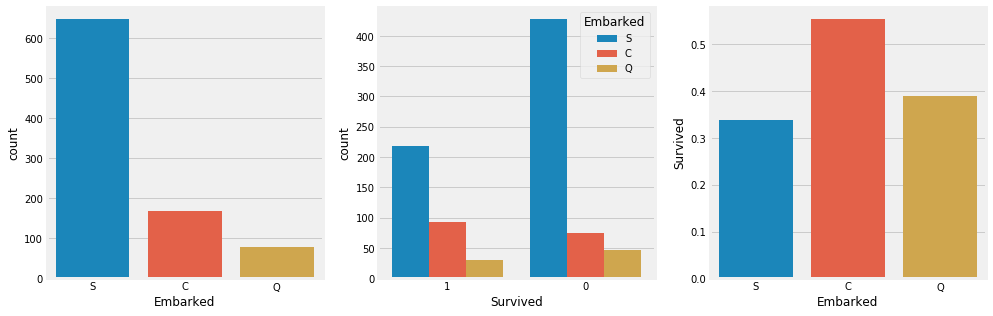

In [59]:
# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# plot
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# sns.factorplot('Embarked',data=titanic_df,kind='count',order=['S','C','Q'],ax=axis1)
# sns.factorplot('Survived',hue="Embarked",data=titanic_df,kind='count',order=[1,0],ax=axis2)
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)
000

[Text(0,0,'With Family'), Text(0,0,'Alone')]

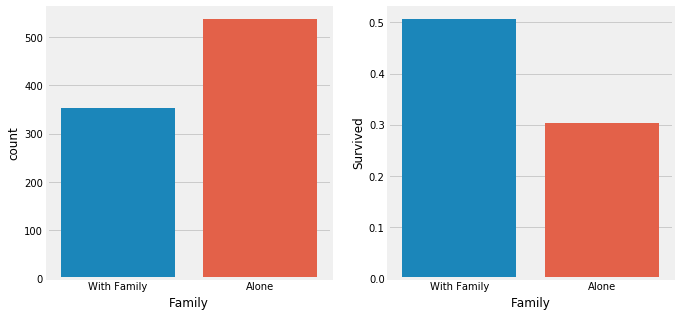

In [60]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Family', data=titanic_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = titanic_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)



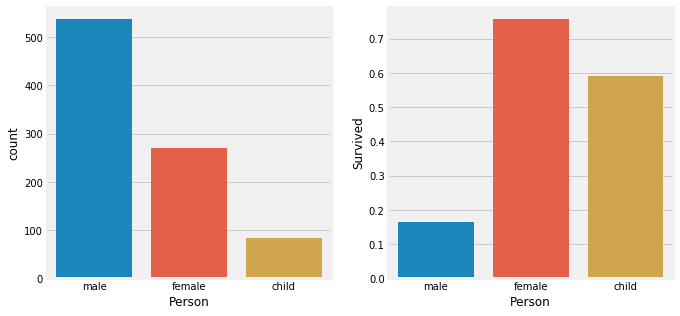

In [61]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

titanic_df
    
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

### Continous feature

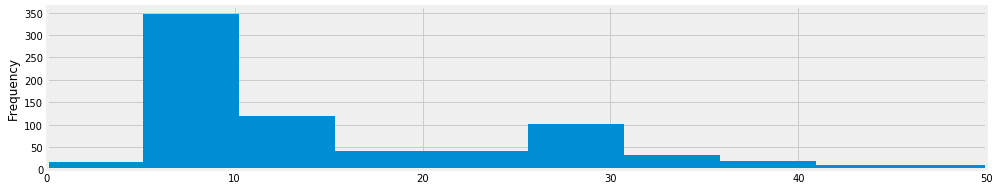

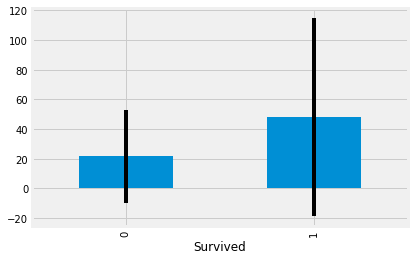

In [62]:
# Fare

# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

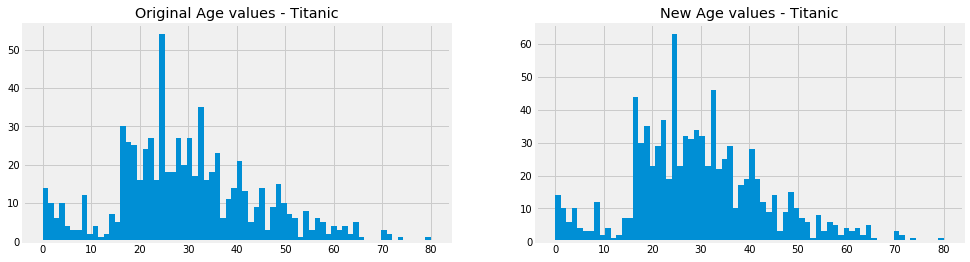

In [63]:
# Age 

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# axis3.set_title('Original Age values - Test')
# axis4.set_title('New Age values - Test')

# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# plot original Age values
# NOTE: drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
# test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)
        
# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)
#test_df['Age'].hist(bins=70, ax=axis4)

### Ordinal Features

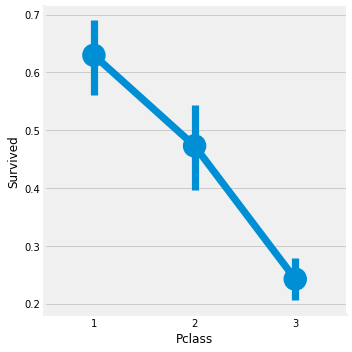

In [64]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

In [65]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

## Part3: Predictive Modeling

## Turning the following cells into a reusable and callable script

### INPUT:
- target var file name, predictor vars file name, output directory, optional model pickle file

### OUTPUT:
- average cv metrics table. csv
- average ROC and Lift charts .jpg
- completed cv metrics table. csv
- box plot of metrics comparison .jpg
- confusion matrix plot. jpg

In [66]:
 #importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import roc_curve,roc_auc_score,f1_score
import numpy as np


In [67]:
# Voating classifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft')
ensemble=ensemble_lin_rbf.fit(X_train,Y_train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [ ]:
# Hyperparameter search for adaboosting
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.2,0.4,0.6,0.8]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True, cv=10)
gd.fit(X_train,y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [38]:
# Hyperparameter search for random forest
n_estimators=list(range(100,1100,100))
hyper={'n_estimators':n_estimators, "min_samples_leaf": [10,50,100,200,500]}
rfgd=GridSearchCV(estimator=RandomForestClassifier(random_state = 0),param_grid=hyper,verbose=True, cv=10)
rfgd.fit(X_train,y_train)
print(rfgd.best_score_)
print(rfgd.best_estimator_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  6.8min finished


0.792937399679
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


## Generate average ROC and Lift Charts for  all the models using10 fold cross validation
ROC Curve:
    ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

Lift Chart:
    The lift curve is a popular technique in direct marketing. One useful way to think of a lift curve is to consider a data mining model that attempts to identify the likely responders to a mailing by assigning each case a probability of responding" score.

In [42]:
'''
10 fold Cross Validation and Record the socring metrics
'''
scoring = {'acc': 'accuracy',
           'prec': 'precision_macro',
           'rec': 'recall_macro',
           'f1':make_scorer(f1_score),
           'auc': make_scorer(roc_auc_score)
          }
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
res = {}
classifiers=['Linear Svm','Logistic Regression','Ada Boosting','Random Forest','Ensemble']
models=[svm.SVC(kernel='linear'),LogisticRegression(),gd.best_estimator_,rfgd.best_estimator_,ensemble_lin_rbf]
for i in models:
    model = i
    scores = cross_validate(model,X_train,y_train, cv = kfold,scoring = scoring,return_train_score= False)
    #print (scores)
    for k in list(scores.keys()):
        if k in res.keys():
            res[k].append(scores[k])
        else:
            res[k] = [scores[k]]


In [44]:
'''
Append the mean values of scoring metrics from cross valiation for each model
'''
avgDict = {}
for k,v in res.items():
    # v is the list of grades for student k
    avgDict[k] = np.mean(v,axis = 1)

new_models_dataframe2=pd.DataFrame(avgDict,index=classifiers)       
new_models_dataframe2

,fit_time,score_time,test_acc,test_auc,test_f1,test_prec,test_rec
Linear Svm,0.719308,0.010200,0.791398,0.780230,0.728721,0.779961,0.780230
Logistic Regression,0.002400,0.002996,0.797849,0.780673,0.725332,0.788919,0.780673
Ada Boosting,0.839411,0.239299,0.804327,0.789409,0.738615,0.797165,0.789409
Random Forest,0.766010,0.186499,0.786508,0.768336,0.706874,0.782413,0.768336
Ensemble,1.985920,0.179202,0.804224,0.789154,0.734139,0.796590,0.789154


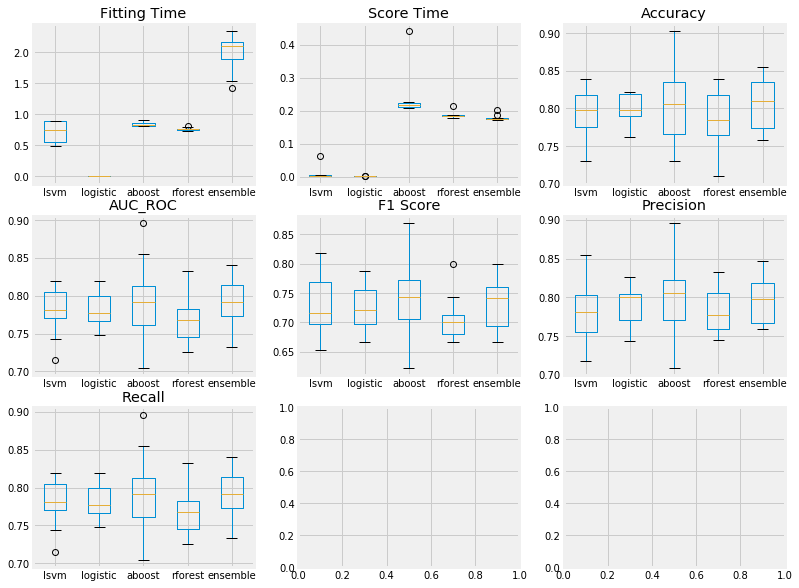

In [45]:
'''
Boxplot visualization of scoring metrics
'''

f,ax=plt.subplots(3,3,figsize=(12,10))
box=pd.DataFrame(res['fit_time'],index=['lsvm','logistic','aboost','rforest','ensemble'])
box.T.boxplot(ax=ax[0,0])
ax[0,0].set_title('Fitting Time')
box=pd.DataFrame(res['score_time'],index=['lsvm','logistic','aboost','rforest','ensemble'])
box.T.boxplot(ax=ax[0,1])
ax[0,1].set_title('Score Time')
box=pd.DataFrame(res['test_acc'],index=['lsvm','logistic','aboost','rforest','ensemble'])
box.T.boxplot(ax=ax[0,2])
ax[0,2].set_title('Accuracy')
box=pd.DataFrame(res['test_auc'],index=['lsvm','logistic','aboost','rforest','ensemble'])
box.T.boxplot(ax=ax[1,0])
ax[1,0].set_title('AUC_ROC')
box=pd.DataFrame(res['test_f1'],index=['lsvm','logistic','aboost','rforest','ensemble'])
box.T.boxplot(ax=ax[1,1])
ax[1,1].set_title('F1 Score')
box=pd.DataFrame(res['test_prec'],index=['lsvm','logistic','aboost','rforest','ensemble'])
box.T.boxplot(ax=ax[1,2])
ax[1,2].set_title('Precision')
box=pd.DataFrame(res['test_rec'],index=['lsvm','logistic','aboost','rforest','ensemble'])
box.T.boxplot(ax=ax[2,0])
ax[2,0].set_title('Recall')
plt.show()

Logistic regression can be used to easily discern inference from the predictor estimates. Also, logistic regression is a standard approach to modeling within academia, industry and State Farm when the target variable is binary. 

A logistic model assumes that the independent variable is binary, that the observations are independent, and that the log odds of the dependent variable is a linear function of the independent variables. Logistic regression also requires a large sample size relative to the number of parameters in the model and it is desirable that there be low multicollinearity so that the model will be more stable when there are minor changes in the variable levels.


The random forest model (e.g., classification tree methods) is a more complex modeling method. Below are some key benefits of using the method. 

 Classification tree methods are robust to outliers 

 Powerful and accurate 

 Good performance on many problems including non linear 

 

The random forest model has several limitations, many of which can be mitigated through careful application of the modeling techniques. Below are key limitations of using this method: 

 Interpretability of the model 

 Overfitting can easily occur 

 Need to choose the number of trees

Adaboosting has 

We can get a summarized result with the help of confusion matrix, which shows where did the model go wrong, or which class did the model predict wrong.

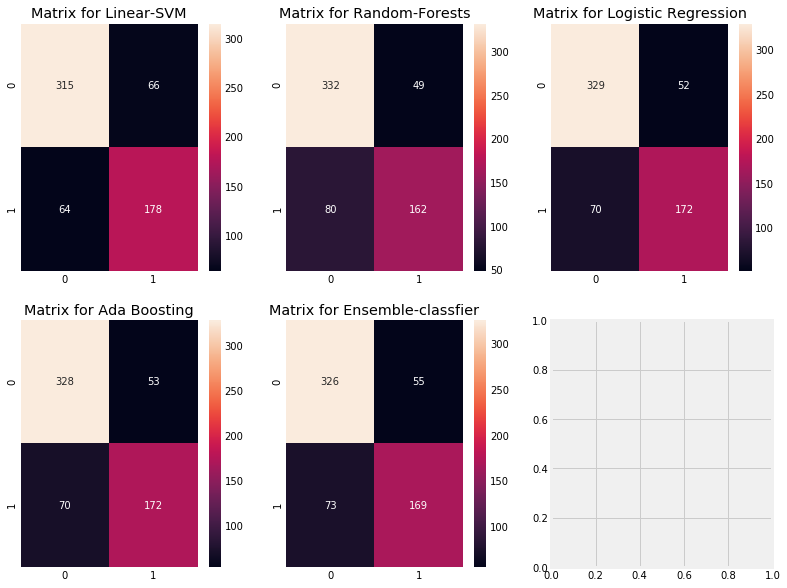

In [46]:
f,ax=plt.subplots(2,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(rfgd.best_estimator_,X_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(gd.best_estimator_,X_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Ada Boosting')
y_pred = cross_val_predict(ensemble_lin_rbf,X_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Ensemble-classfier')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

# Ensemble ROC Chart - Train

In [53]:
'''
10 fold Cross Validation and Record the socring metrics
'''
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
model = ensemble_lin_rbf
score = cross_validate(model,X_train,y_train, cv = kfold,scoring = scoring)
print(score)
for k in list(score.keys()):
    if k in res.keys():
        res[k].append(score[k])
    else:
        res[k] = [score[k]]

{'fit_time': array([ 4.29805136,  4.32404947,  3.84979606,  2.69650173,  3.47144008,
        3.88748384,  4.14522266,  3.34907603,  3.95924187,  3.99831605]), 'score_time': array([ 0.32385492,  0.33885455,  0.47092533,  0.31499076,  0.32784629,
        0.38161802,  0.31994367,  0.37693024,  0.32798243,  0.41085577]), 'test_acc': array([ 0.76190476,  0.80952381,  0.80952381,  0.83870968,  0.83870968,
        0.79032258,  0.82258065,  0.75806452,  0.85483871,  0.77419355]), 'train_acc': array([ 0.93392857,  0.91607143,  0.925     ,  0.91800357,  0.92869875,
        0.92335116,  0.92691622,  0.92869875,  0.91622103,  0.93226381]), 'test_prec': array([ 0.75872093,  0.79456522,  0.76686047,  0.81997677,  0.83243243,
        0.77891892,  0.81666667,  0.76682987,  0.84659091,  0.8004386 ]), 'train_prec': array([ 0.94359886,  0.92630405,  0.93670743,  0.92770624,  0.9370808 ,
        0.93176029,  0.93704071,  0.93846615,  0.92784946,  0.94280402]), 'test_rec': array([ 0.73421053,  0.79456522, 

In [150]:
# for training data
prediction_en = ensemble.predict(X_train)
prediction_en_prob = ensemble.predict_proba(X_train)
print("===>",scores)
print("===>", y_train)
print(prediction_en_prob)

===> {'fit_time': array([ 3.394696  ,  3.46365356,  2.82656074,  2.3789463 ,  4.54442739,
        3.18073273,  4.39248681,  3.52294111,  4.40473557,  3.84617496]), 'score_time': array([ 0.05250859,  0.03388405,  0.06797099,  0.07758307,  0.06698537,
        0.05204368,  0.06529331,  0.07307482,  0.05462956,  0.08273983]), 'test_auc': array([ 0.69421053,  0.79456522,  0.75      ,  0.79616725,  0.81891892,
        0.73574561,  0.78372352,  0.74679487,  0.80546265,  0.78466387])}
===> 857    1
52     1
386    0
124    0
578    0
549    1
118    0
12     0
157    0
127    1
653    1
235    0
785    0
241    1
351    0
862    1
851    0
753    0
532    0
485    0
695    0
475    0
17     1
476    0
533    1
416    1
345    1
242    0
344    0
170    0
      ..
72     0
845    0
537    1
677    1
849    1
874    1
174    0
87     0
551    0
486    1
705    0
314    0
396    0
600    1
472    1
70     0
599    1
804    1
754    1
277    0
723    0
9      1
359    1
707    1
763    1
835    1


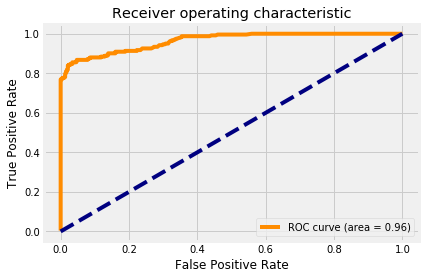

In [135]:
from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_train, prediction_en_prob[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

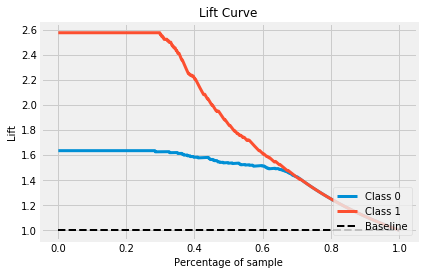

In [33]:
import scikitplot as skplt
skplt.metrics.plot_lift_curve(y_train, prediction_en_prob)
plt.show()

# Ensemble ROC Chart - Test

In [34]:
# for training data
prediction_en = ensemble.predict(X_test)
prediction_en_prob = ensemble.predict_proba(X_test)

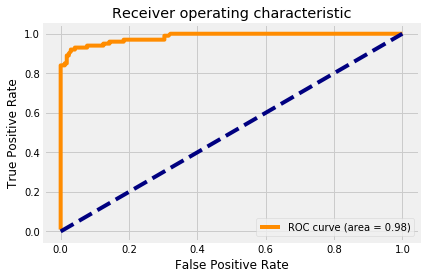

In [35]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, prediction_en_prob[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

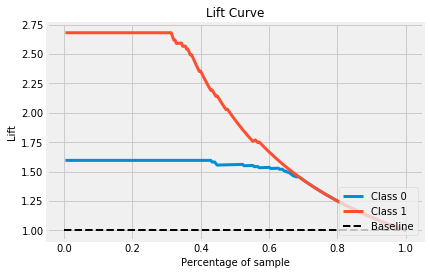

In [36]:
import scikitplot as skplt
skplt.metrics.plot_lift_curve(y_test, prediction_en_prob)
plt.show()

# mean & std dev

In [37]:
means = gd.cv_results_['mean_test_score']
stds = gd.cv_results_['std_test_score']
params = gd.cv_results_['params']

In [38]:
for mean, std, params in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.780 (+/-0.060) for {'learning_rate': 0.05, 'n_estimators': 100}
0.796 (+/-0.071) for {'learning_rate': 0.05, 'n_estimators': 200}
0.796 (+/-0.086) for {'learning_rate': 0.05, 'n_estimators': 300}
0.798 (+/-0.079) for {'learning_rate': 0.05, 'n_estimators': 400}
0.793 (+/-0.094) for {'learning_rate': 0.05, 'n_estimators': 500}
0.796 (+/-0.094) for {'learning_rate': 0.05, 'n_estimators': 600}
0.798 (+/-0.104) for {'learning_rate': 0.05, 'n_estimators': 700}
0.796 (+/-0.108) for {'learning_rate': 0.05, 'n_estimators': 800}
0.795 (+/-0.109) for {'learning_rate': 0.05, 'n_estimators': 900}
0.796 (+/-0.108) for {'learning_rate': 0.05, 'n_estimators': 1000}
0.793 (+/-0.083) for {'learning_rate': 0.2, 'n_estimators': 100}
0.791 (+/-0.101) for {'learning_rate': 0.2, 'n_estimators': 200}
0.798 (+/-0.112) for {'learning_rate': 0.2, 'n_estimators': 300}
0.803 (+/-0.127) for {'learning_rate': 0.2, 'n_estimators': 400}
0.804 (+/-0.129) for {'learning_rate': 0.2, 'n_estimators': 500}
0.806 (+/-0.13

# ROC for SVM - train dataset

In [39]:
# Build your classifier
classifier = svm.SVC(kernel='linear', probability=True)

# Train it on the entire training data set
svm = classifier.fit(X_train, y_train)

# Get predictions on the test set
y_pred = svm.predict(X_test)
prediction_prob_svc = svm.predict_proba(X_train)

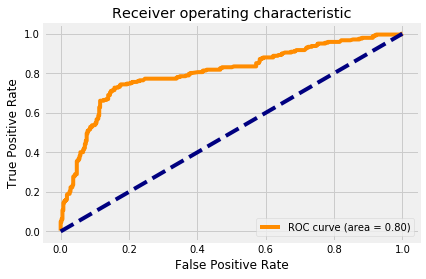

In [40]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_train, prediction_prob_svc[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

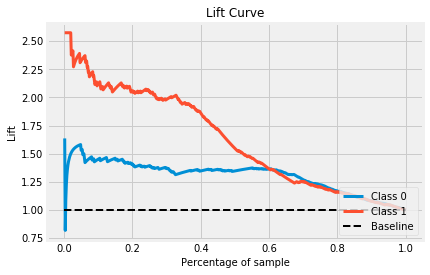

In [41]:
import scikitplot as skplt
skplt.metrics.plot_lift_curve(y_train, prediction_prob_svc)
plt.show()

In [42]:
# Train it on the entire training data set
svm = classifier.fit(X_test, y_test)

# Get predictions on the test set
y_pred = svm.predict(X_test)
prediction_prob_svc = svm.predict_proba(X_test)

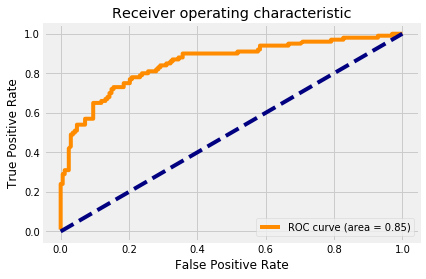

In [43]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, prediction_prob_svc[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

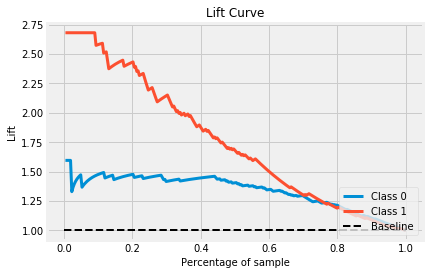

In [44]:
import scikitplot as skplt
skplt.metrics.plot_lift_curve(y_test, prediction_prob_svc)
plt.show()

## roc for adaboost - train set

In [45]:
# for training data
prediction = gd.predict(X_train)
prediction_prob = gd.best_estimator_.predict_proba(X_train)

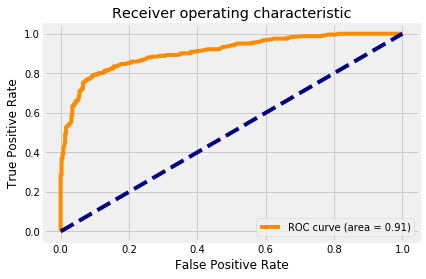

In [46]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_train, prediction_prob[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

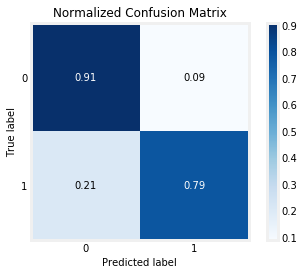

In [47]:
skplt.metrics.plot_confusion_matrix(y_train, prediction, normalize=True)
plt.show()

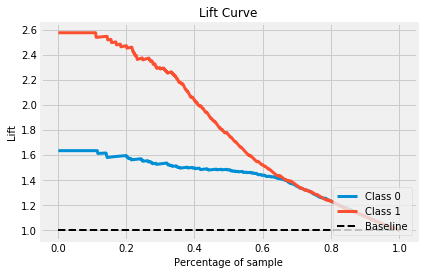

In [48]:
skplt.metrics.plot_lift_curve(y_train,  prediction_prob)
plt.show()

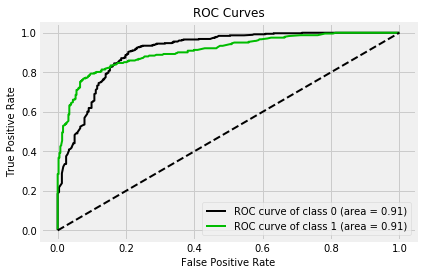

In [49]:
import scikitplot as skplt
skplt.metrics.plot_roc(y_train, prediction_prob, plot_macro=False, plot_micro=False)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

## Gain-chart adaboost - train set

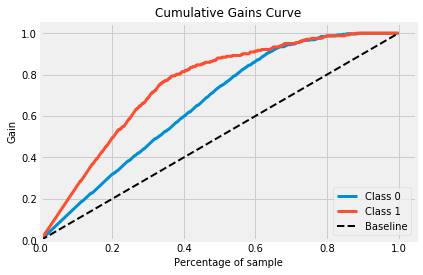

In [50]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_train, prediction_prob)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.show()

## roc for adaboost - validation set

In [51]:
# for validation data
prediction = gd.predict(X_test)
prediction_prob = gd.best_estimator_.predict_proba(X_test)

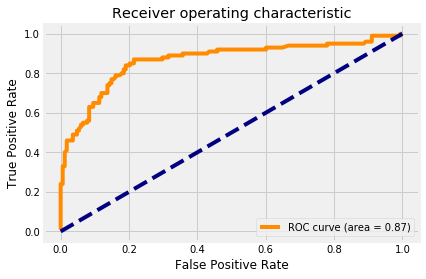

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, prediction_prob[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

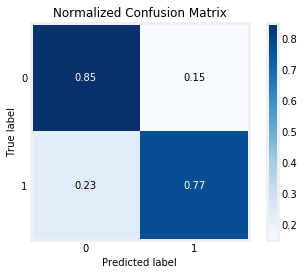

In [53]:
skplt.metrics.plot_confusion_matrix(y_test, prediction, normalize=True)
plt.show()

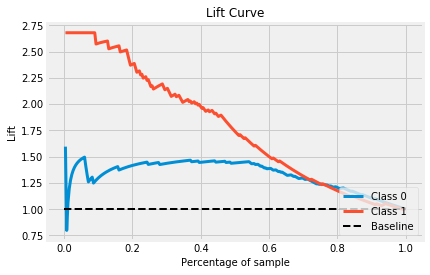

In [54]:
skplt.metrics.plot_lift_curve(y_test,  prediction_prob)
plt.show()

## Gain-chart adaboost - validation set

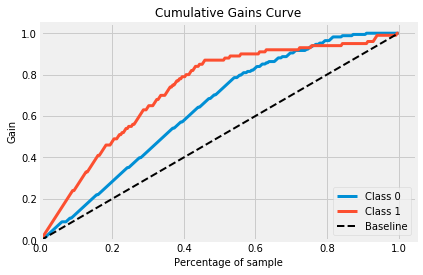

In [55]:
skplt.metrics.plot_cumulative_gain(y_test, prediction_prob)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.show()

# grid search random forest - 10 fold cv

In [56]:
means_rf = rfgd.cv_results_['mean_test_score']
stds_rf = rfgd.cv_results_['std_test_score']
params_rf = rfgd.cv_results_['params']

In [57]:
for mean, std, params in zip(means_rf, stds_rf, params_rf):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.795 (+/-0.097) for {'min_samples_leaf': 10, 'n_estimators': 100}
0.788 (+/-0.094) for {'min_samples_leaf': 10, 'n_estimators': 200}
0.790 (+/-0.088) for {'min_samples_leaf': 10, 'n_estimators': 300}
0.791 (+/-0.080) for {'min_samples_leaf': 10, 'n_estimators': 400}
0.793 (+/-0.087) for {'min_samples_leaf': 10, 'n_estimators': 500}
0.795 (+/-0.070) for {'min_samples_leaf': 10, 'n_estimators': 600}
0.796 (+/-0.074) for {'min_samples_leaf': 10, 'n_estimators': 700}
0.795 (+/-0.074) for {'min_samples_leaf': 10, 'n_estimators': 800}
0.796 (+/-0.067) for {'min_samples_leaf': 10, 'n_estimators': 900}
0.795 (+/-0.070) for {'min_samples_leaf': 10, 'n_estimators': 1000}
0.770 (+/-0.045) for {'min_samples_leaf': 50, 'n_estimators': 100}
0.772 (+/-0.035) for {'min_samples_leaf': 50, 'n_estimators': 200}
0.759 (+/-0.053) for {'min_samples_leaf': 50, 'n_estimators': 300}
0.759 (+/-0.053) for {'min_samples_leaf': 50, 'n_estimators': 400}
0.761 (+/-0.052) for {'min_samples_leaf': 50, 'n_estimators':

# roc for rf - train

In [58]:
# for training data
prediction_rf = rfgd.predict(X_train)
prediction_rf_prob = rfgd.best_estimator_.predict_proba(X_train)

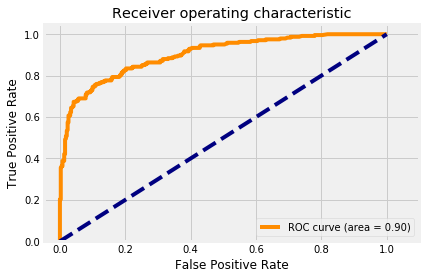

In [59]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_train, prediction_rf_prob[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

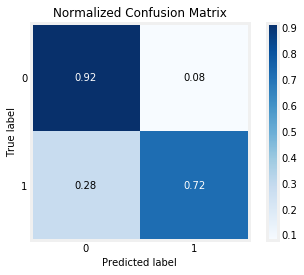

In [60]:
skplt.metrics.plot_confusion_matrix(y_train, prediction_rf, normalize=True)
plt.show()

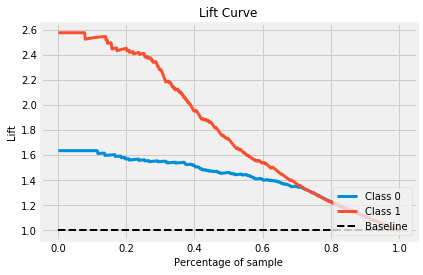

In [61]:
skplt.metrics.plot_lift_curve(y_train,  prediction_rf_prob)
plt.show()

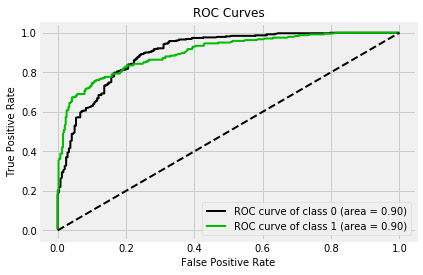

In [62]:
skplt.metrics.plot_roc(y_train, prediction_rf_prob, plot_macro=False, plot_micro=False)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

## Gain chart - rf - train

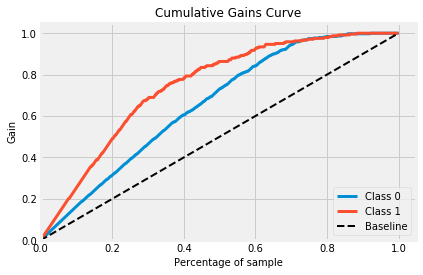

In [63]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_train, prediction_rf_prob)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.show()

## roc for rf - validation

In [64]:
# for validation data
prediction_rf = rfgd.predict(X_test)
prediction_rf_prob = rfgd.best_estimator_.predict_proba(X_test)

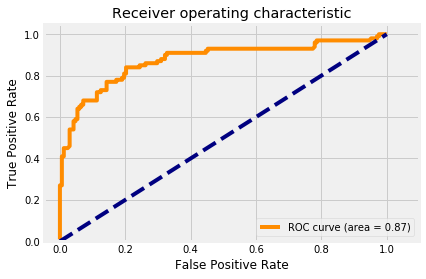

In [65]:
fpr, tpr, thresholds = roc_curve(y_test, prediction_rf_prob[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

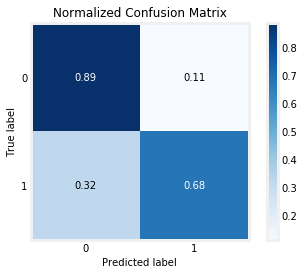

In [66]:
skplt.metrics.plot_confusion_matrix(y_test, prediction_rf, normalize=True)
plt.show()

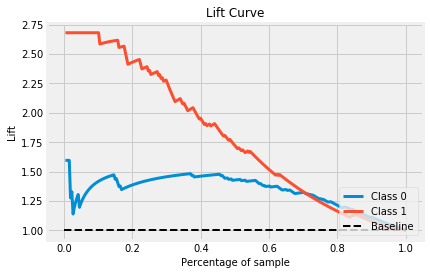

In [67]:
skplt.metrics.plot_lift_curve(y_test,  prediction_rf_prob)
plt.show()

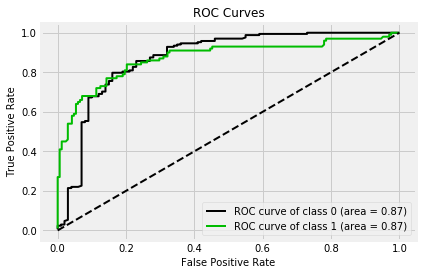

In [68]:
skplt.metrics.plot_roc(y_test, prediction_rf_prob, plot_macro=False, plot_micro=False)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

## Gain chart -rf - validation set

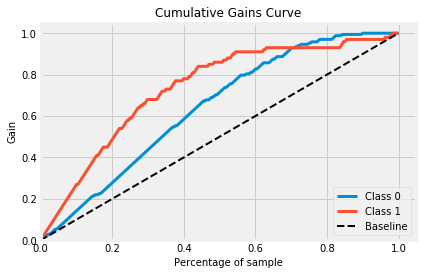

In [69]:
skplt.metrics.plot_cumulative_gain(y_test, prediction_rf_prob)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.show()

# Grid search logit regression 

In [70]:
import multiprocessing
num_workers = multiprocessing.cpu_count()
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "fit_intercept":[True, False]} # l1 lasso l2 ridge

logreg=LogisticRegression(random_state=0)
logreg_cv=GridSearchCV(logreg,grid,cv=10, n_jobs=num_workers, verbose=1)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   33.9s


tuned hpyerparameters :(best parameters)  {'C': 10.0, 'fit_intercept': True, 'penalty': 'l1'}
accuracy : 0.805778491172


[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   34.7s finished


# mean & std dev

In [71]:
means_lg = logreg_cv.cv_results_['mean_test_score']
stds_lg = logreg_cv.cv_results_['std_test_score']
params_lg = logreg_cv.cv_results_['params']

In [72]:
for mean, std, params in zip(means_lg, stds_lg, params_lg):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.626 (+/-0.040) for {'C': 0.001, 'fit_intercept': True, 'penalty': 'l1'}
0.658 (+/-0.091) for {'C': 0.001, 'fit_intercept': True, 'penalty': 'l2'}
0.626 (+/-0.040) for {'C': 0.001, 'fit_intercept': False, 'penalty': 'l1'}
0.661 (+/-0.090) for {'C': 0.001, 'fit_intercept': False, 'penalty': 'l2'}
0.653 (+/-0.092) for {'C': 0.01, 'fit_intercept': True, 'penalty': 'l1'}
0.697 (+/-0.090) for {'C': 0.01, 'fit_intercept': True, 'penalty': 'l2'}
0.653 (+/-0.092) for {'C': 0.01, 'fit_intercept': False, 'penalty': 'l1'}
0.697 (+/-0.102) for {'C': 0.01, 'fit_intercept': False, 'penalty': 'l2'}
0.775 (+/-0.079) for {'C': 0.10000000000000001, 'fit_intercept': True, 'penalty': 'l1'}
0.799 (+/-0.063) for {'C': 0.10000000000000001, 'fit_intercept': True, 'penalty': 'l2'}
0.775 (+/-0.079) for {'C': 0.10000000000000001, 'fit_intercept': False, 'penalty': 'l1'}
0.774 (+/-0.046) for {'C': 0.10000000000000001, 'fit_intercept': False, 'penalty': 'l2'}
0.799 (+/-0.063) for {'C': 1.0, 'fit_intercept': True,

# roc for logit - train

In [73]:
# for training data
prediction_lg = logreg_cv.predict(X_train)
prediction_lg_prob = logreg_cv.best_estimator_.predict_proba(X_train)

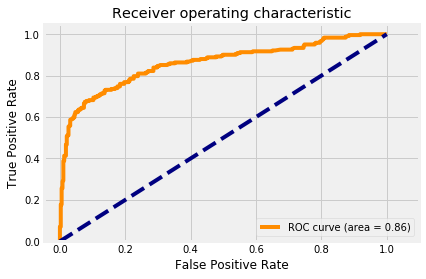

In [74]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_train, prediction_lg_prob[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

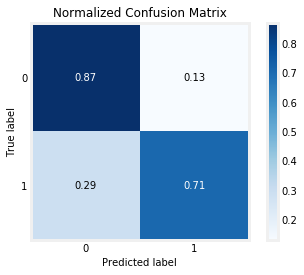

In [75]:
skplt.metrics.plot_confusion_matrix(y_train, prediction_lg, normalize=True)
plt.show()

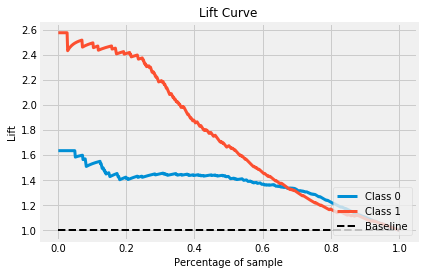

In [76]:
skplt.metrics.plot_lift_curve(y_train,  prediction_lg_prob)
plt.show()

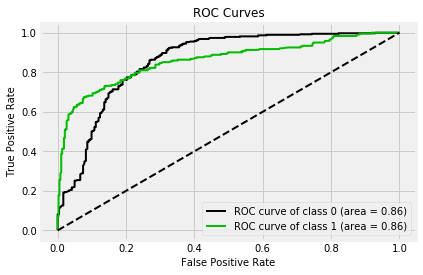

In [77]:
skplt.metrics.plot_roc(y_train, prediction_lg_prob, plot_macro=False, plot_micro=False)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

# Gain chart - logit - train

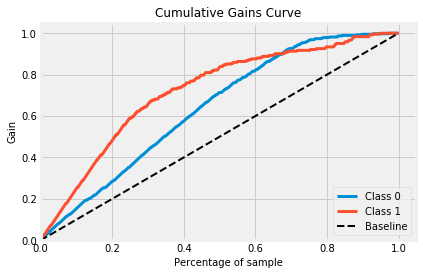

In [78]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_train, prediction_lg_prob)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.show()

# roc for logit - validation

In [79]:
# for validation data
prediction_lg = logreg_cv.predict(X_test)
prediction_lg_prob = logreg_cv.best_estimator_.predict_proba(X_test)

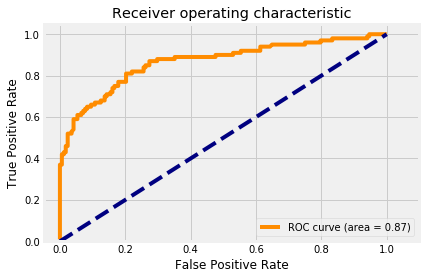

In [80]:
fpr, tpr, thresholds = roc_curve(y_test, prediction_lg_prob[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

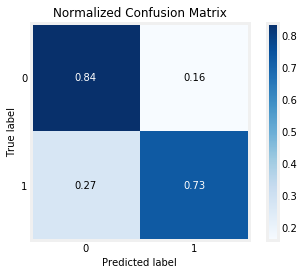

In [81]:
skplt.metrics.plot_confusion_matrix(y_test, prediction_lg, normalize=True)
plt.show()

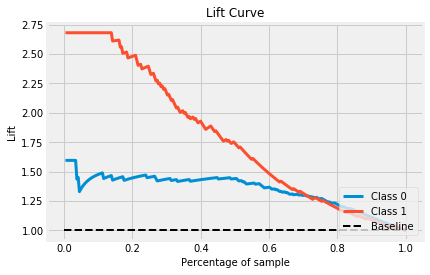

In [82]:
skplt.metrics.plot_lift_curve(y_test,  prediction_lg_prob)
plt.show()

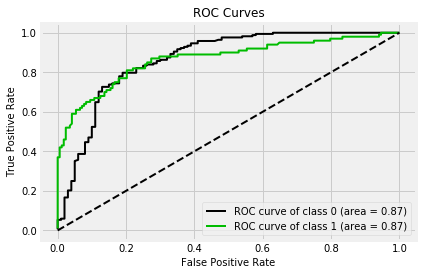

In [83]:
skplt.metrics.plot_roc(y_test, prediction_lg_prob, plot_macro=False, plot_micro=False)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

# Gain chart - logit - validation set

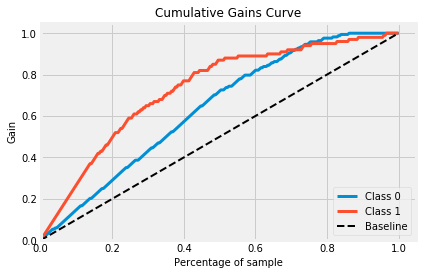

In [84]:
skplt.metrics.plot_cumulative_gain(y_test, prediction_lg_prob)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.show()

# roc - rf vs adaboost vs logit - train data

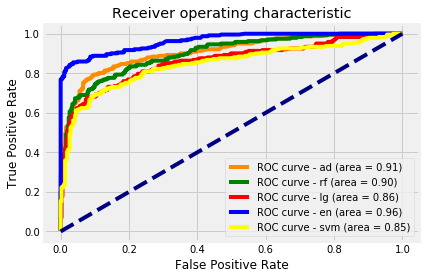

In [88]:
prediction_prob = gd.best_estimator_.predict_proba(X_train)
prediction_rf_prob = rfgd.best_estimator_.predict_proba(X_train)
prediction_lg_prob = logreg_cv.best_estimator_.predict_proba(X_train)
prediction_en_prob = ensemble.predict_proba(X_train)
prediction_svm_prob = classifier.predict_proba(X_train)

fpr, tpr, thresholds = roc_curve(y_train, prediction_prob[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, prediction_rf_prob[:,1])
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_train, prediction_lg_prob[:,1])
fpr_en, tpr_en, thresholds_en = roc_curve(y_train, prediction_en_prob[:,1])
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, prediction_svm_prob[:,1])

roc_auc = auc(fpr, tpr)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_lg = auc(fpr_lg, tpr_lg)
roc_auc_en = auc(fpr_en, tpr_en)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve - ad (area = %0.2f)' % roc_auc)
plt.plot(fpr_rf, tpr_rf, color='green', label='ROC curve - rf (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_lg, tpr_lg, color='red', label='ROC curve - lg (area = %0.2f)' % roc_auc_lg)
plt.plot(fpr_en, tpr_en, color='blue', label='ROC curve - en (area = %0.2f)' % roc_auc_en)
plt.plot(fpr_svm, tpr_svm, color='yellow', label='ROC curve - svm (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# roc - rf vs adaboost - validation data

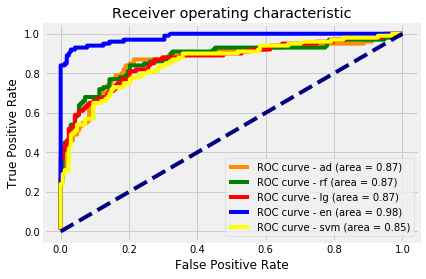

In [93]:
prediction_prob = gd.best_estimator_.predict_proba(X_test)
prediction_rf_prob = rfgd.best_estimator_.predict_proba(X_test)
prediction_lg_prob = logreg_cv.predict_proba(X_test)
prediction_en_prob = ensemble.predict_proba(X_test)
prediction_svm_prob = classifier.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, prediction_prob[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, prediction_rf_prob[:,1])
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, prediction_lg_prob[:,1])
fpr_en, tpr_en, thresholds_en = roc_curve(y_test, prediction_en_prob[:,1])
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, prediction_svm_prob[:,1])

roc_auc = auc(fpr, tpr)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_lg = auc(fpr_lg, tpr_lg)
roc_auc_en = auc(fpr_en, tpr_en)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve - ad (area = %0.2f)' % roc_auc)
plt.plot(fpr_rf, tpr_rf, color='green', label='ROC curve - rf (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_lg, tpr_lg, color='red', label='ROC curve - lg (area = %0.2f)' % roc_auc_lg)
plt.plot(fpr_en, tpr_en, color='blue', label='ROC curve - en (area = %0.2f)' % roc_auc_en)
plt.plot(fpr_svm, tpr_svm, color='yellow', label='ROC curve - svm (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()